In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns

from scrapping import scrap_reviews

import datetime as dt 
import re 
import string 

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 

import csv
import requests
from io import StringIO

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preparation

In [2]:
app_reviews_df = scrap_reviews('com.twitter.android', count=4000, file_name='twitter_reviews.csv')
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,12528742-76a5-4997-8f56-69863f468241,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Hello (●’◡’●)ﾉ. Ini tolong di perbaiki. Soalny...,3,318,10.55.1-release.0,2024-08-27 21:46:28,None,None,10.55.1-release.0
1,3ad8dcfc-cae6-4c73-8155-a6b732e09abf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tolong diperbaiki akun saya sering log-out sen...,1,22,10.58.0-release.0,2024-09-14 02:59:34,None,None,10.58.0-release.0
2,da13d50e-33e3-4443-b219-f9df87ab2356,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolonglah balikkan fitur ""Like"" di profil. Itu...",2,309,10.55.0-release.0,2024-08-23 00:27:39,None,None,10.55.0-release.0
3,993bc9be-5fd9-442b-a2fa-55b4c6052ae3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"jaringan bagus, wifi bagus tapi kenapa loading...",1,888,10.55.1-release.0,2024-08-23 11:55:07,None,None,10.55.1-release.0
4,68ae6082-7a1d-4913-a34c-8fb0f681fe53,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sedikit masukan padahal udh lama pake aplikasi...,2,222,10.55.1-release.0,2024-08-25 16:05:02,None,None,10.55.1-release.0


In [3]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              45000 non-null  object        
 1   userName              45000 non-null  object        
 2   userImage             45000 non-null  object        
 3   content               45000 non-null  object        
 4   score                 45000 non-null  int64         
 5   thumbsUpCount         45000 non-null  int64         
 6   reviewCreatedVersion  31349 non-null  object        
 7   at                    45000 non-null  datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            31349 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 3.8+ MB


In [4]:
clean_df = app_reviews_df.dropna(subset=['content'])
clean_df = clean_df.drop_duplicates()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 0 to 44999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              45000 non-null  object        
 1   userName              45000 non-null  object        
 2   userImage             45000 non-null  object        
 3   content               45000 non-null  object        
 4   score                 45000 non-null  int64         
 5   thumbsUpCount         45000 non-null  int64         
 6   reviewCreatedVersion  31349 non-null  object        
 7   at                    45000 non-null  datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            31349 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 4.1+ MB


In [5]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya",
                          "gaa","loh","kah","woi","woii","woy", "nih", "gwe", "gua"
                          "yah", "gw", "kaya", "kek", "gk", "gue"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    
    words = text.split()

    
    stemmed_words = [stemmer.stem(word) for word in words]

    
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [6]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual",
              "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "yg": "yang", "tdk": "tidak",
              "lg": "lagi", "sy": "saya", "jd": "jadi", "trus": "terus", "pdhl": "padahal", "apk": "aplikasi",
              "tp": "tapi", "sampe": "sampai", "trs": "terus", "udh": "udah", "jg": "juga"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [7]:
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['content'].apply(fix_slangwords)

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['text_slangwords'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_casefoldingText'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [8]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_slangwords,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_akhir
0,12528742-76a5-4997-8f56-69863f468241,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Hello (●’◡’●)ﾉ. Ini tolong di perbaiki. Soalny...,3,318,10.55.1-release.0,2024-08-27 21:46:28,None,None,10.55.1-release.0,Hello (●’◡’●)ﾉ. Ini tolong di perbaiki. Soalny...,Hello ﾉ Ini tolong di perbaiki Soalnya akuku s...,hello ﾉ ini tolong di perbaiki soalnya akuku s...,"[hello, ﾉ, ini, tolong, di, perbaiki, soalnya,...","[hello, ﾉ, tolong, perbaiki, akuku, suka, gitu...",hello ﾉ tolong perbaiki akuku suka gitu maksud...
1,3ad8dcfc-cae6-4c73-8155-a6b732e09abf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tolong diperbaiki akun saya sering log-out sen...,1,22,10.58.0-release.0,2024-09-14 02:59:34,None,None,10.58.0-release.0,Tolong diperbaiki akun saya sering log-out sen...,Tolong diperbaiki akun saya sering logout send...,tolong diperbaiki akun saya sering logout send...,"[tolong, diperbaiki, akun, saya, sering, logou...","[tolong, diperbaiki, akun, logout, terkunci, c...",tolong diperbaiki akun logout terkunci capek a...
2,da13d50e-33e3-4443-b219-f9df87ab2356,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolonglah balikkan fitur ""Like"" di profil. Itu...",2,309,10.55.0-release.0,2024-08-23 00:27:39,None,None,10.55.0-release.0,"Tolonglah balikkan fitur ""Like"" di profil. Itu...",Tolonglah balikkan fitur Like di profil Itu sa...,tolonglah balikkan fitur like di profil itu sa...,"[tolonglah, balikkan, fitur, like, di, profil,...","[tolonglah, balikkan, fitur, like, profil, men...",tolonglah balikkan fitur like profil menarik l...
3,993bc9be-5fd9-442b-a2fa-55b4c6052ae3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"jaringan bagus, wifi bagus tapi kenapa loading...",1,888,10.55.1-release.0,2024-08-23 11:55:07,None,None,10.55.1-release.0,"jaringan bagus, wifi bagus tapi kenapa loading...",jaringan bagus wifi bagus tapi kenapa loading ...,jaringan bagus wifi bagus tapi kenapa loading ...,"[jaringan, bagus, wifi, bagus, tapi, kenapa, l...","[jaringan, bagus, wifi, bagus, loading, video,...",jaringan bagus wifi bagus loading video menit ...
4,68ae6082-7a1d-4913-a34c-8fb0f681fe53,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sedikit masukan padahal udh lama pake aplikasi...,2,222,10.55.1-release.0,2024-08-25 16:05:02,None,None,10.55.1-release.0,sedikit masukan padahal udah lama pake aplikas...,sedikit masukan padahal udah lama pake aplikas...,sedikit masukan padahal udah lama pake aplikas...,"[sedikit, masukan, padahal, udah, lama, pake, ...","[masukan, udah, pake, aplikasinya, update, his...",masukan udah pake aplikasinya update history l...


In [9]:
def fetch_lexicon_data(url):
    """
    Fungsi untuk mengambil data lexicon dari URL yang diberikan (dalam format CSV).
    
    Args:
    url (str): URL file CSV yang berisi data lexicon.
    
    Returns:
    dict: Kamus yang berisi kata sebagai kunci dan skornya sebagai nilai.
    """
    lexicon = dict()

    response = requests.get(url)

    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        
        for row in reader:
            lexicon[row[0]] = int(row[1])

    else:
        print(f"Failed to fetch data from {url}")
    
    return lexicon

In [10]:
lexicon_positive = fetch_lexicon_data('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lexicon_negative = fetch_lexicon_data('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

print("Lexicon Positive Sample:", list(lexicon_positive.items())[:5])
print("Lexicon Negative Sample:", list(lexicon_negative.items())[:5])

Lexicon Positive Sample: [('hai', 3), ('merekam', 2), ('ekstensif', 3), ('paripurna', 1), ('detail', 2)]
Lexicon Negative Sample: [('putus tali gantung', -2), ('gelebah', -2), ('gobar hati', -2), ('tersentuh (perasaan)', -1), ('isak', -5)]


In [11]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
        
    return score, polarity

In [12]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

negative    27526
positive    17474
Name: polarity, dtype: int64


In [13]:
negative_texts = clean_df[clean_df['polarity'] == 'negative']
random_negative_text = negative_texts.sample(n=10)
print(random_negative_text['text_akhir'].values[0:9])

['lelet banget ni kpn makiin diperbaharui jelek'
 'aplikasi bagus senang mengunakan aplikasi'
 'akun tangguhkan akun akun asli akun palsuakun spam'
 'tolong perbaiki izin masuk twitter login verifikasi kode telepon menunggu pengiriman kode verifikasi login mohon solusi mengatasi terkait thanks'
 'lemot oy buruk aja' 'buruk aplikasi berhenti pdhal nyalain aplikasi'
 'apasi g bisa² login daritadi enakgjelas psti ggera update soasik'
 'twitter gua isinya bokep dipake' 'susah log bokep gratis']


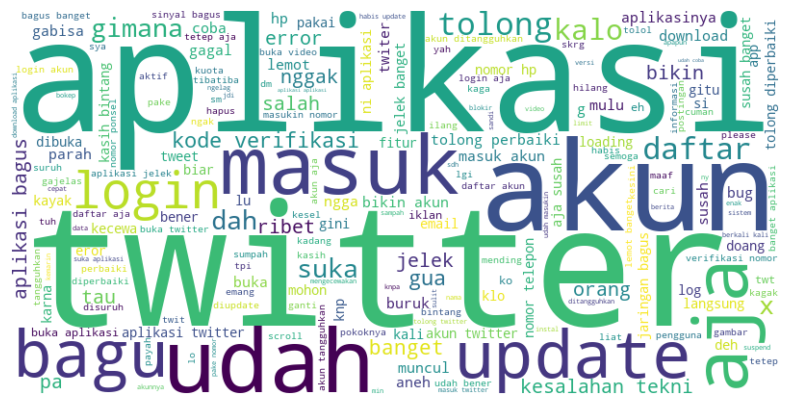

In [14]:
negative_words = clean_df[clean_df['polarity'] == 'negative']
text = ' '.join(negative_words['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- Hasil kategorisasi label negatif menggunakan lexicon sudah menunjukkan hasil yang baik.
- Analisis WordCloud menunjukkan bahwa review negatif disebabkan oleh:
  - Bug
  - Kinerja lambat
  - Error saat login
  - Kendala saat menggunakan aplikasi

In [15]:
positive_texts = clean_df[clean_df['polarity'] == 'positive']
random_positive_text = positive_texts.sample(n=10)

print(random_positive_text['text_akhir'].values[0:9])

['muter video detikabi ngelag maju jnjuuk'
 'bermanfaat nambah ilmu harmonis' 'memuaskan' 'diupdate twitter dibuka'
 'lgi stalk akun pas udah nyampe pertengahan refresh gmn sihhh'
 'memasukan nomer telpon akun sandi'
 'ko pas nunggu kode nyatiba tlpn warga knp' 'pas udah update ngelag'
 'update']


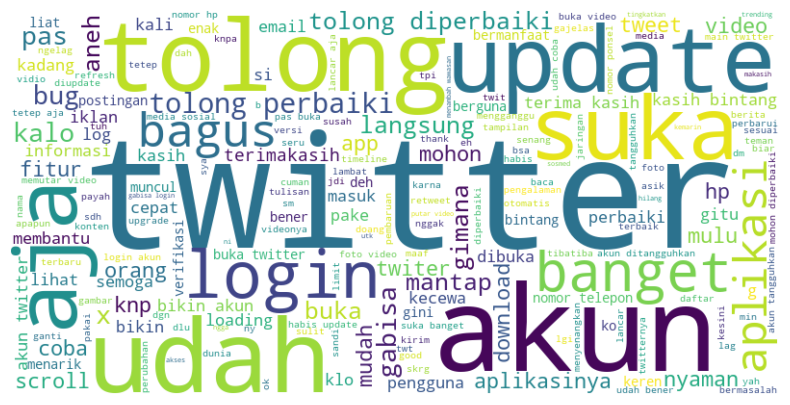

In [16]:
positive_words = clean_df[clean_df['polarity'] == 'positive']
text = ' '.join(positive_words['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- Hasil kategorisasi label positif menggunakan lexicon sudah menunjukkan hasil yang baik.
- Masih terdapat beberapa data yang salah dikategorikan.
- Terdapat catatan dari review positif sehingga kata "tolong" dan "tolong perbaiki" termasuk kata yang sering muncul.
- Analisis WordCloud menunjukkan bahwa review positif disebabkan oleh:
  - fitur baru yang membantu
  - Nyaman digunakan

# Preprocessing

In [17]:
X = clean_df['text_akhir']
y = clean_df['polarity']

tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

features_df

,aja,aktif,akun,aman,aneh,apapun,aplikasi,aplikasinya,app,baca,...,udah,ulang,uninstall,update,verifikasi,versi,video,vidio,wifi,yah
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.198300,0.00000,0.0,0.0,...,0.117590,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,0.145253,0.0,0.246807,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.364844,0.0,0.162072,0.0,0.000000,0.0
2,0.000000,0.0,0.149220,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.152907,0.0,0.486149,0.0
4,0.175059,0.0,0.000000,0.0,0.0,0.0,0.000000,0.25059,0.0,0.0,...,0.167618,0.0,0.0,0.186869,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
44996,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
44997,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
44998,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(y_train.value_counts())

negative    22007
positive    13993
Name: polarity, dtype: int64


In [19]:
def preprocess_text_data_padded(df, text_column, label_column, num_words=5000, maxlen=100, test_size=0.2, random_state=42):
    """
    Fungsi untuk memproses teks menjadi sekuens numerik, melakukan padding, dan membagi data menjadi set latih dan uji.

    Args:
    df (pd.DataFrame): DataFrame yang berisi data teks dan label.
    text_column (str): Nama kolom yang berisi teks untuk diproses.
    label_column (str): Nama kolom yang berisi label (misalnya 'positive' atau 'negative').
    num_words (int): Jumlah maksimal kata yang ingin digunakan dalam tokenizer.
    maxlen (int): Panjang maksimal sekuens setelah padding.
    test_size (float): Proporsi data untuk data uji.
    random_state (int): Seed untuk pengacakan dalam pembagian data.

    Returns:
    X_train (np.array): Data fitur latih yang sudah diproses.
    X_test (np.array): Data fitur uji yang sudah diproses.
    y_train (pd.Series): Label latih.
    y_test (pd.Series): Label uji.
    tokenizer (Tokenizer): Tokenizer yang sudah di-fit pada teks.
    """
    
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(df[text_column]) 
    X_seq = tokenizer.texts_to_sequences(df[text_column])

    X_pad = pad_sequences(X_seq, maxlen=maxlen)

    y = df[label_column].replace({'negative': 0, 'positive': 1})

    X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test, tokenizer

X_train_nn, X_test_nn, y_train_nn, y_test_nn, tokenizer = preprocess_text_data_padded(clean_df, 'text_akhir', 'polarity', num_words=5000, maxlen=100, test_size=0.2, random_state=42)

print(X_train_nn.shape, X_test_nn.shape)

(36000, 100) (9000, 100)


# Training and Testing

In [20]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train.toarray(), y_train)

y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9527222222222222
Random Forest - accuracy_test: 0.834


In [21]:
logistic_regression = LogisticRegression()

logistic_regression.fit(X_train.toarray(), y_train)

y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8498333333333333
Logistic Regression - accuracy_test: 0.8481111111111111


In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=100),
    tf.keras.layers.LSTM(units=16, return_sequences=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/10
450/450 [==============================] - 36s 67ms/step - loss: 0.3671 - accuracy: 0.8379 - val_loss: 0.2259 - val_accuracy: 0.9076
Epoch 2/10
450/450 [==============================] - 28s 62ms/step - loss: 0.1661 - accuracy: 0.9399 - val_loss: 0.1824 - val_accuracy: 0.9307
Epoch 3/10
450/450 [==============================] - 28s 63ms/step - loss: 0.1094 - accuracy: 0.9621 - val_loss: 0.1866 - val_accuracy: 0.9312
Epoch 4/10
450/450 [==============================] - 31s 69ms/step - loss: 0.0776 - accuracy: 0.9748 - val_loss: 0.2042 - val_accuracy: 0.9339
Epoch 5/10
450/450 [==============================] - 31s 68ms/step - loss: 0.0606 - accuracy: 0.9815 - val_loss: 0.2177 - val_accuracy: 0.9358


In [24]:
y_pred_lstm = (model.predict(X_test_nn) > 0.5).astype("int32")

accuracy_lstm = accuracy_score(y_test_nn, y_pred_lstm)
print(f"Test Accuracy: {accuracy_lstm:.4f}")

282/282 [==============================] - 6s 16ms/step
Test Accuracy: 0.9290


# Results

Text(0, 0.5, 'Accuracy')

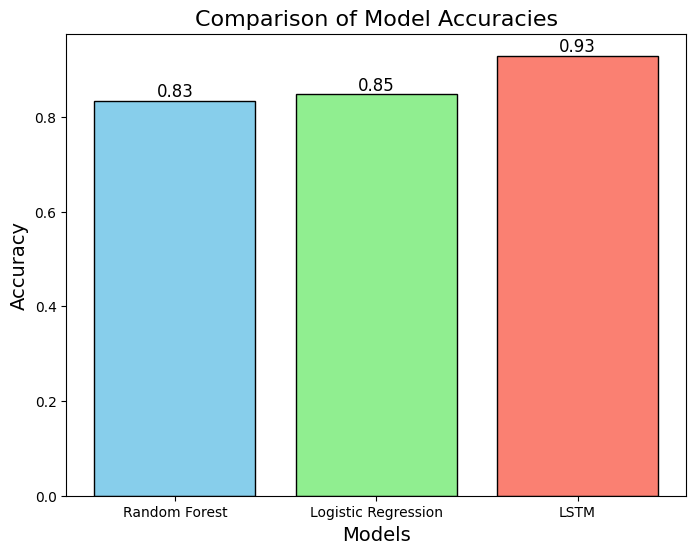

In [25]:
models = ['Random Forest', 'Logistic Regression', 'LSTM']
accuracies = [accuracy_test_rf, accuracy_test_lr, accuracy_lstm]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.title('Comparison of Model Accuracies', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)